## 3D Beamforming Application

this is an app-like jupyter notebook. 


Naming convention of recording file and scanned models:
[Condition]_[distance]_[extranote]

conditions List:
HP1: Jabra ENVOLVE2 75
HP2: Jabra ENVOLVE2 65 Flex
HP3: Jabra ENVOLVE

EP: Earphone, my airpods

GL: VUE Glass

VVS: Volume velocity source

LS: Loudspeaker - Two Units very close to each others - Subwoofer diameter
                                                        10.7cm
                                                      - Twitter dimention: 
                                                      width 2.4cm, heigth 3.4cm

LSTV: Loudspeaker Taped Vent

LSTVBF: Loudspeaker Taped Vend and placed on forward one backward


----------------

Distance were measured by a regular ruler, which is a rough number, not necessarily reflect the actural distance

----------------

In [1]:
# this block is for testing, allowd to reload the module soundfieldanalysis
%load_ext autoreload
%aimport SoundFieldAnalysis, acoular, bf3d_prep
%autoreload 1
%aimport

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Modules to reload:
SoundFieldAnalysis acoular bf3d_prep

Modules to skip:



In [3]:
# select the recording file
from bf3d_prep import bf3d_prep

recording_prep = bf3d_prep(rootfolder = 'Recordings', filetype = '.mat')

Dropdown(description='Select:', options=('..', 'AP-side-0.6m-12.8kHz-1k6fft.mat', 'bgNoise-HP2-0.70m-2.mat', '…

Button(description='Select', style=ButtonStyle())

Output()

Output()

Output()

In [4]:
# select the pcd file
pcd_prep = bf3d_prep(rootfolder = 'postPCD', filetype = '.ply')

Dropdown(description='Select:', options=('..', 'AP-align_20231216_122743', 'AP-modify_20231208_161053', 'AP-no…

Button(description='Select', style=ButtonStyle())

Output()

Output()

Output()

In [5]:

# import the PCD file and recording data
import open3d as o3d
from data_importer import PointCloudManager, DataExtractor

"""
This block processes point cloud data and extracts audio recording data.

Returns:
- pcd_mic (open3d.geometry.PointCloud): Point cloud data from microphone.
- pcd (open3d.geometry.PointCloud): Point cloud data.
- filtered_pcd (open3d.geometry.PointCloud): Filtered point cloud data.
- recording (numpy.ndarray): Audio recording data.
"""

recording_file = recording_selector.selected_file
pcd_file = pcd_selector.selected_file[:-12]

manager = PointCloudManager()
pcd_mic, pcd, cpcd = manager.load_models(pcd_file)

extractor = DataExtractor(recording_file)
recording = extractor.load_data()

In [4]:
# This block will use to reduce the background noise from measured signal

Measured_signal1 = DataExtractor(f'Recordings/JABRA-recordings/GoodSeal-HP1-12.8k-signalChannel.mat')
Measured_signal1 = Measured_signal1.load_data()
Measured_signal2 = DataExtractor(f'Recordings/JABRA-recordings/FrontLose-HP1-12.8k-signalChannel.mat')
Measured_signal2 = Measured_signal2.load_data()
Measured_signal3 = DataExtractor(f'Recordings/JABRA-recordings/BackLose-HP1-12.8k-signalChannel.mat')
Measured_signal3 = Measured_signal3.load_data()
Backgroud_noise = DataExtractor(f'Recordings/JABRA-recordings/BGN-HP1-12.8k.mat')
Backgroud_noise = Backgroud_noise.load_data()

import numpy as np
from scipy.signal import stft, istft

def spectral_subtraction(measured_signal, background_noise, fs=32768):
    """
    Perform generalized spectral subtraction.

    Parameters:
    measured_signal (np.ndarray): The noisy signal, shape (channels, samples).
    background_noise (np.ndarray): The background noise signal, shape (channels, samples).
    fs (int): Sampling rate.

    Returns:
    np.ndarray: The denoised signal, same shape as input signals.
    """
    # Parameters for STFT
    nperseg = 256  # Number of samples per STFT segment
    noverlap = nperseg // 2  # Overlap between segments
    nfft = nperseg  # Number of FFT points

    # Placeholder for the output
    denoised_signal = np.zeros_like(measured_signal)
    signal_spectrum = []
    noise_spectrum = []

    for ch in range(measured_signal.shape[0]):
        # Compute the STFT of both signals
        f, _, Zxx_signal = stft(measured_signal[ch, :], fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
        _, _, Zxx_noise = stft(background_noise[ch, :], fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

        # Estimate the magnitude spectrum of noise
        noise_mag = np.abs(Zxx_noise)

        # Perform spectral subtraction
        subtracted_spectrum = np.abs(Zxx_signal) - noise_mag
        subtracted_spectrum[subtracted_spectrum < 0] = 0

        # Reconstruct the signal using the original phase
        denoised_spectrum = subtracted_spectrum * np.exp(1j * np.angle(Zxx_signal))

        # Convert back to time domain
        _, denoised_time_signal = istft(denoised_spectrum, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
        denoised_signal[ch, :len(denoised_time_signal)] = denoised_time_signal
        signal_spectrum.append(np.sum(Zxx_signal, axis=1))
        noise_spectrum.append(np.sum(Zxx_noise, axis=1))
        time_channelnuber = Zxx_signal.shape[1]

    return denoised_signal, signal_spectrum, noise_spectrum, subtracted_spectrum, denoised_spectrum, f, time_channelnuber

# Using the function
denoised_signal, signal_spectrum, noise_spectrum, subtracted_spectrum, denoised_spectrum, frequencys, time_channelnuber = spectral_subtraction(Measured_signal, Backgroud_noise)


NameError: name 'Measured_signal' is not defined

In [6]:
# this block setup the plotter default aspect ratio and font size

import matplotlib.pyplot as plt
import seaborn as sns

w = 12 / 1.1
h = w * (3 / 10)
ASPECT = (w, h)  # w, h in inches

font_size = 12

# Enable LaTeX rendering + set font size
plt.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.size": font_size,
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.titlesize": font_size,
    }
)

In [7]:
# initialize the Beamformer plotter

from SoundFieldAnalysis import SoundFieldAnalysis
import open3d as o3d

BF_analysis = SoundFieldAnalysis(pcd_mic, recording, cpcd, freq=9000)
freq_list = BF_analysis.get_freq_list(freq_range=[3000, 3020], T = 10)

In [5]:
# plot the measured signal and denoised signal and background noise
import matplotlib.pyplot as plt
import numpy as np

sg_spec_db = BF_analysis.dbspl(np.sum(np.array(signal_spectrum), axis=0)/time_channelnuber)
noise_spec_db = BF_analysis.dbspl(np.sum(np.array(noise_spectrum), axis=0)/time_channelnuber)
snr_spec_db = sg_spec_db - noise_spec_db

# plot the measured signal and denoised signal
plt.figure(figsize=ASPECT)
plt.subplot(121)
plt.semilogx(frequencys, sg_spec_db)
plt.semilogx(frequencys, noise_spec_db)
#plt.semilogx(frequencys, BF_analysis.dbspl(np.sum(signal_spectrum-noise_spectrum, axis=1)/subtracted_spectrum.shape[1]))
plt.title('Microphone signal and Background noise')
plt.xlabel('frequency [Hz]')
plt.ylabel('dB SPL')
plt.legend(['Measured signal - good sealed','Background noise', 'SNR'])
plt.grid()

plt.subplot(122)
plt.semilogx(frequencys, snr_spec_db)
plt.title('SNR')
plt.xlabel('frequency [Hz]')
plt.ylabel('dB SPL')
plt.grid()
plt.tight_layout()

plt.show()


NameError: name 'signal_spectrum' is not defined

In [ ]:
# plot the measured signal and denoised signal and background noise
import matplotlib.pyplot as plt
import numpy as np

sg_spec_db = BF_analysis.dbspl(np.sum(np.array(signal_spectrum), axis=0)/time_channelnuber)
noise_spec_db = BF_analysis.dbspl(np.sum(np.array(noise_spectrum), axis=0)/time_channelnuber)
snr_spec_db = sg_spec_db - noise_spec_db

# plot the measured signal and denoised signal
plt.figure(figsize=ASPECT)
plt.subplot(121)
plt.semilogx(frequencys, sg_spec_db)
plt.semilogx(frequencys, noise_spec_db)
#plt.semilogx(frequencys, BF_analysis.dbspl(np.sum(signal_spectrum-noise_spectrum, axis=1)/subtracted_spectrum.shape[1]))
plt.title('Microphone signal and Background noise')
plt.xlabel('frequency [Hz]')
plt.ylabel('dB SPL')
plt.legend(['Measured signal - good sealed','Background noise', 'SNR'])
plt.grid()

plt.subplot(122)
plt.semilogx(frequencys, snr_spec_db)
plt.title('SNR')
plt.xlabel('frequency [Hz]')
plt.ylabel('dB SPL')
plt.grid()
plt.tight_layout()

plt.show()


NameError: name 'signal_spectrum' is not defined

In [6]:
# This block will play the reduced noise signal
import numpy as np
import sounddevice as sd

def play_sound(sound, channel, sample_rate=44100):
    """Play the sound on a specified channel (0 or 1)"""
    if sound.ndim == 1:
        # If the sound is mono, duplicate it for both channels
        sound = np.tile(sound[:, np.newaxis], (1, 2))
    
    # Create a stereo sound array with one channel set to zero
    stereo_sound = np.zeros_like(sound)
    
    if channel == 0:
        # Play on left channel
        stereo_sound[:, 0] = sound[:, 0]
    elif channel == 1:
        # Play on right channel
        stereo_sound[:, 1] = sound[:, 1]
    else:
        raise ValueError("Channel must be 0 or 1")
    
    sd.play(stereo_sound, samplerate=sample_rate)
    sd.wait()


# play the denoised signal
play_sound(denoised_signal[0], channel=0, sample_rate=32768)

NameError: name 'denoised_signal' is not defined

In [8]:

import numpy as np
import tables

tables.file._open_files.close_all()
fs = (recording.shape[1])/10
datamat7 = np.array(recording.T, dtype='float32')

h5filemat7 = tables.open_file("temp.h5", mode='w', 
                             title='three_sources')
earraymat7 = h5filemat7.create_earray('/', 'time_data', obj=datamat7)
display(earraymat7)
h5filemat7.root.time_data.set_attr('sample_freq',fs)
h5filemat7.close()

/time_data (EArray(327680, 36)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (455, 36)

In [ ]:
# this blcok will save the point cloud data as grid for calculation to xml file

save_pcd_to_xml(pcd = cpcd, xml_filename = "pcd_temp.xml", subgrid_name="default")
save_pcd_to_xml(pcd = pcd_mic, xml_filename = "pcd_mic_temp.xml", subgrid_name="default")

In [10]:
# this block will convet the point cloud data to mesh
# and save the mesh as grid for calculation to xml file


from bf3d_prep import FolderSelector, reverse_sound_field

rsf = reverse_sound_field(np.asarray(pcd_mic.points), cpcd, None, freq_list)

cpcd_mesh = rsf.gen_mesh(pcd = cpcd)

triangles = np.asarray(cpcd_mesh.triangles)
vertices = np.asarray(cpcd_mesh.vertices)
normals = np.asarray(cpcd_mesh.triangle_normals)
angles = []
centers = []

for tri, normal in zip(triangles, normals):
    triangle_vertice = vertices[tri]
    center = np.mean(triangle_vertice, axis=0)
    centers.append(center)

# load centers into o3d point cloud
centers = np.array(centers)
centers_pcd = o3d.geometry.PointCloud()
centers_pcd.points = o3d.utility.Vector3dVector(centers)

save_pcd_to_xml(pcd = centers_pcd, xml_filename = "pcd_temp.xml", subgrid_name="default")


In [45]:
display(np.array(centers).shape)

(238325, 3)

In [76]:
from os import path

# imports from acoular
import acoular
from acoular import __file__ as bpath, L_p, MicGeom, PowerSpectra,\
RectGrid3D, BeamformerBase, BeamformerCleansc, \
SteeringVector, WNoiseGenerator, PointSource, SourceMixer

# other imports
from numpy import mgrid, arange, array, arccos, pi, cos, sin, sum
import mpl_toolkits.mplot3d
from pylab import figure, show, scatter, subplot, imshow, title, colorbar,\
xlabel, ylabel


micgeofile = 'pcd_mic_temp.xml'
# generate test data, in real life this would come from an array measurement
mg = MicGeom( from_file=micgeofile)

ts = acoular.TimeSamples(name="temp.h5")

ps = acoular.PowerSpectra( time_data=ts, block_size=128, window="Hanning" )

# Create an instance of ImportGrid
grid_importer = acoular.ImportGrid()

# Set the path to your XML file
grid_importer.from_file = 'pcd_temp.xml'

# Call the method to import grid positions
grid_importer.import_gpos()

#rg = acoular.RectGrid( x_min=-1, x_max=1,
                       #y_min=-1, y_max=1,
                       #z=0.5, increment=0.01 )

st = acoular.SteeringVector(mics=mg )
st.grid = grid_importer
st.steer_type = 'true location'



In [77]:
bb = acoular.BeamformerBase(freq_data=ps, steer=st, r_diag=True)
#bc = BeamformerCapon(freq_data=f, steer=st, cached=False)
#be = BeamformerEig(freq_data=f, steer=st, r_diag=True, n=54)
bm = acoular.BeamformerMusic(freq_data=ps, steer=st, n=1)
#bd = acoular.BeamformerDamas(beamformer=bb, n_iter=100)
#bdp = BeamformerDamasPlus(beamformer=bb, n_iter=100)
#bo = BeamformerOrth(freq_data=f, steer=st, r_diag=True, eva_list=list(range(38,54)))
bs = BeamformerCleansc(freq_data=ps, steer=st, r_diag=True)
#bcmf = BeamformerCMF(freq_data=f, steer=st, method='LassoLarsBIC')
#bl = BeamformerClean(beamformer=bb, n_iter=100)
bf = acoular.BeamformerFunctional(freq_data=ps, steer=st, r_diag=False, gamma=4)

In [78]:
print(f"Frequency range: {ps.freq_range} Hz")

Frequency range: [  64. 4096.] Hz


In [11]:
cfreq = 560 # frequency of interest
pm = bs.synthetic(cfreq,3)
Lm = acoular.L_p(pm)
plotter, p_range = BF_analysis.plot(Lm, dynamic_range=20, max_crop=0, plot_mesh = True, opacity=True)
# Make sure the rendering is complete
plotter.show()

Widget(value="<iframe src='http://localhost:62121/index.html?ui=P_0x2c493777a90_1&reconnect=auto' style='width…

In [77]:
cfreq = 400 # frequency of interest
import panel as pn

#figure(1,)
#i1 = 1 #no of subplot
for b in (bb, bm, bs, bf):
    #subplot(4,4,i1)
    #i1 += 1
    pm = b.synthetic(cfreq,3)
    Lm = acoular.L_p(pm)
    plotter, p_range = BF_analysis.plot(Lm, dynamic_range=5, max_crop=0, plot_mesh = True, opacity=True)
    # Make sure the rendering is complete
    plotter.show(auto_close=False)
    #file_name = f'Results/3dplot/{b.__class__.__name__}_freq:{cfreq}_{recording_dropdown.value[0:-5]}.html'
    file_name = f'{b.__class__.__name__}_freq_{cfreq}_{recording_selector.selected_file[0:-4]}'
    print(file_name)
    plotter.close()


Widget(value="<iframe src='http://localhost:56568/index.html?ui=P_0x21ca1c17580_0&reconnect=auto' style='width…

BeamformerBase_freq_800_LSTVBF-1.6kHz-0.9m-0.07Vrms


Widget(value="<iframe src='http://localhost:56568/index.html?ui=P_0x21ca1c177f0_0&reconnect=auto' style='width…

BeamformerMusic_freq_800_LSTVBF-1.6kHz-0.9m-0.07Vrms


Widget(value="<iframe src='http://localhost:56568/index.html?ui=P_0x21c267a7fd0_0&reconnect=auto' style='width…

BeamformerCleansc_freq_800_LSTVBF-1.6kHz-0.9m-0.07Vrms


Widget(value="<iframe src='http://localhost:56568/index.html?ui=P_0x21ca1bd77f0_0&reconnect=auto' style='width…

BeamformerFunctional_freq_800_LSTVBF-1.6kHz-0.9m-0.07Vrms


In [16]:
freq_list = [250, 500, 1000, 2000, 4000, 8000] # frequency of interest
import panel as pn

#figure(1,)
#i1 = 1 #no of subplot
for b in (bm, bs):
    for cfreq in freq_list:
        pm = b.synthetic(cfreq,3)
        Lm = acoular.L_p(pm)
        plotter, p_range = BF_analysis.plot(Lm, dynamic_range=5, max_crop=0, plot_mesh = True, opacity=True)
        # Make sure the rendering is complete
        plotter.show(auto_close=False)
        #file_name = f'Results/3dplot/{b.__class__.__name__}_freq:{cfreq}_{recording_dropdown.value[0:-5]}.html'
        file_name = f'{b.__class__.__name__}_freq_{cfreq}_{recording_selector.selected_file[0:-4]}'
        print(file_name)
        plotter.close()


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f19017bf70_0&reconnect=auto' style='width…

BeamformerMusic_freq_250_GoodSeal-HP1-12.8k-signalChannel


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f194e40310_0&reconnect=auto' style='width…

BeamformerMusic_freq_500_GoodSeal-HP1-12.8k-signalChannel


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f194e40490_0&reconnect=auto' style='width…

BeamformerMusic_freq_1000_GoodSeal-HP1-12.8k-signalChannel


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f194e40d60_0&reconnect=auto' style='width…

BeamformerMusic_freq_2000_GoodSeal-HP1-12.8k-signalChannel


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f194e403a0_0&reconnect=auto' style='width…

BeamformerMusic_freq_4000_GoodSeal-HP1-12.8k-signalChannel


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f194e41a80_0&reconnect=auto' style='width…

BeamformerMusic_freq_8000_GoodSeal-HP1-12.8k-signalChannel
[('temp_cache.h5', 2)]


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f194d58190_0&reconnect=auto' style='width…

BeamformerCleansc_freq_250_GoodSeal-HP1-12.8k-signalChannel


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f18fff73a0_0&reconnect=auto' style='width…

BeamformerCleansc_freq_500_GoodSeal-HP1-12.8k-signalChannel


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f18f3f5c30_0&reconnect=auto' style='width…

BeamformerCleansc_freq_1000_GoodSeal-HP1-12.8k-signalChannel


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f18f7b4760_0&reconnect=auto' style='width…

BeamformerCleansc_freq_2000_GoodSeal-HP1-12.8k-signalChannel


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f18fff68c0_0&reconnect=auto' style='width…

BeamformerCleansc_freq_4000_GoodSeal-HP1-12.8k-signalChannel


Widget(value="<iframe src='http://localhost:50288/index.html?ui=P_0x1f18f46d8a0_0&reconnect=auto' style='width…

BeamformerCleansc_freq_8000_GoodSeal-HP1-12.8k-signalChannel


In [111]:
freq_list = ps.fftfreq() # frequency of interest
import panel as pn

#figure(1,)
#i1 = 1 #no of subplot
pms = []
for cfreq in freq_list[1:]:
    pm = bf.synthetic(cfreq,0)
    Lm = acoular.L_p(pm)
    pms.append(pm)

[('temp_cache.h5', 6)]


C:\Users\ZHLI\AppData\Local\Temp\ipykernel_23864\673510917.py:8: Warning: Beamforming result may not have been calculated for queried frequency. Check freq_data.ind_low and freq_data.ind_high!
  pm = bf.synthetic(cfreq,0)


In [168]:
from bf3d_prep import FolderSelector, reverse_sound_field

rsf = reverse_sound_field(np.asarray(pcd_mic.points), cpcd, None, freq_list)

re_p_mic = rsf.pressure_at_array_point(freq_list, pms)

shape of r (238325,)
finish the variable setup


c:\ZIM\MasterThesisProject\Stage4\3d_beamforming\bf3d_prep.py:143: RuntimeWarning: invalid value encountered in divide
  term = 2 * j1(k * a * np.sin(theta)) / (k * a * np.sin(theta))


In [171]:
rsf.datas

{'p_hat': array([[ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        ...,
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [-0.+0.j, -0.+0.j, -0.+0.j, ..., -0.+0.j, -0.+0.j, -0.+0.j]]),
 'r': array([5.71565342, 5.71681114, 5.69356903, ..., 5.94065228, 5.79692787,
        6.09171595]),
 'theta': array([[90.92813541, 90.21159629, 89.56750292, ..., 89.80313178,
         88.95200083, 88.65962199],
        [95.19337446, 94.70850727, 94.24966479, ..., 94.25860325,
         93.65155961, 93.26968091],
        [95.79531068, 95.34809092, 94.92308602, ..., 94.91967814,
         94.35735433, 93.9908934 ],
        ...,
        [87.89237079, 87.26325038, 86.68653892, ..., 86.82319588,
         86.06020113, 85.71660415],
        [88.39870646, 87.6500143

In [ ]:
ans = rsf.datas["p_hat"]
plt.plot(ans[:,21:23])

: 

In [151]:
Pf_values = (re_p_mic["Pf_values"])
frequencies = ps.fftfreq()  # Get the list of frequencies
csm = np.array(ps.csm)  # Calculate and get the Cross Spectral Matrix

# calculate the csm of Pf_values
csm_Pf = np.zeros((len(Pf_values), Pf_values.shape[1], Pf_values.shape[1]))
for i in range(len(frequencies[1:])):
    csm_Pf[i] = np.outer(Pf_values[i], Pf_values[i].conj())



In [148]:
error = (csm_Pf - csm[1:,:,:])/csm[1:,:,:] * 100

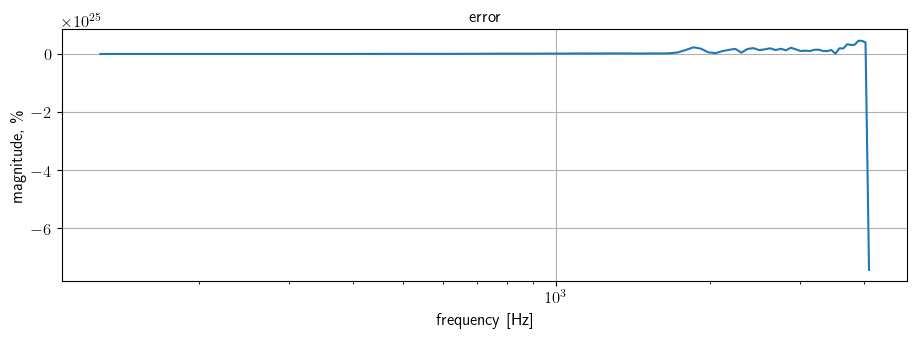

In [149]:
#plot the Pf_values
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=ASPECT)
plt.semilogx(freq_list[1:], (np.sum((error), axis=(1,2))))
#plt.plot(freq_list[1:], (np.sum(csm[1:,:,:], axis=(1,2))))
#plt.plot(freq_list[1:], (np.sum(csm_Pf, axis=(1,2))))
plt.title('error')
plt.xlabel('frequency [Hz]')
plt.ylabel('magnitude, \%')
plt.grid()
plt.show()


In [26]:
bb = acoular.BeamformerMusic( freq_data=ps, steer=st)
#bdams = acoular.BeamformerDamas (beamformer = bb, freq_data=ps, steer=st)
#pm = .synthetic( 6000, 3 )
#Lm = acoular.L_p( pm )

pm = bb.synthetic(5000, 3)
Lm = acoular.L_p(pm)


[('temp_cache.h5', 5)]
[('temp_cache.h5', 6)]


In [13]:
bb_Noise = acoular.BeamformerCleansc ( freq_data=ps, steer=st)


#pm = .synthetic( 6000, 3 )
#Lm = acoular.L_p( pm )

pm_noise = bb_Noise.synthetic( 5000, 2 )
Lm = acoular.L_p( pm )

[('temp_cache.h5', 3)]


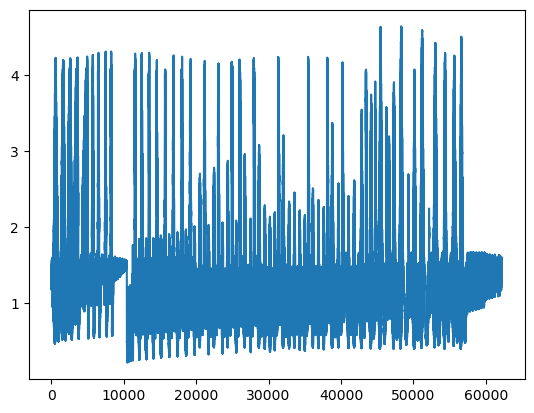

In [27]:
import matplotlib.pyplot as plt

plt.Figure()
plt.plot(Lm)

In [130]:
mesh = rsf.gen_mesh(pcd = cpcd)

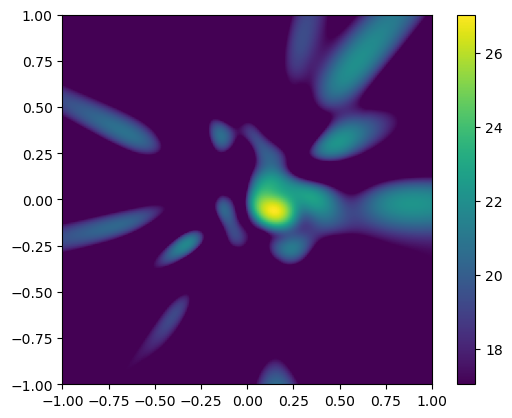

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-10, extent=rg.extend() )
plt.colorbar()

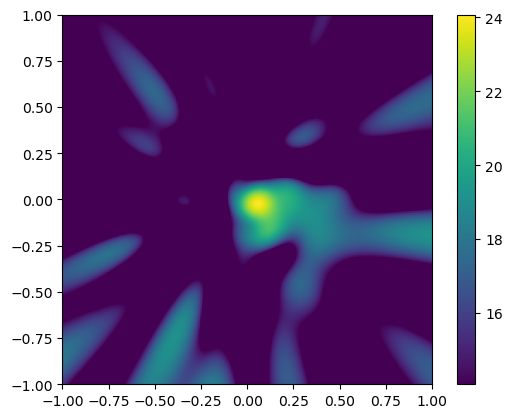

In [ ]:

import matplotlib.pyplot as plt

plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-10, extent=rg.extend() )
plt.colorbar()

In [ ]:
print( ts.numchannels, ts.numsamples, ts.sample_freq )

36 81920 8192.0


In [ ]:
# this block is for testing, allowd to reload the module soundfieldanalysis
%load_ext autoreload
%aimport SoundFieldAnalysis
%autoreload 1
%aimport

Modules to reload:
SoundFieldAnalysis

Modules to skip:



In [ ]:
# create a button for the calculation

# create a checkbox
checkbox = widgets.Checkbox(
    value=False,
    description='chooese if you want to recalculate the results',
    disabled=False,
    indent=False
)

# display the checkbox
display(checkbox)

# use a function to print the checkbox's value
def on_checkbox_change(change):
    if change['new']:  # while the checkbox is checked
        print("recalculate the results")
    else:
        print("Checkbox is False")

# get the checkbox's current value
checkbox.observe(on_checkbox_change, names='value')

Checkbox(value=False, description='chooese if you want to recalculate the results', indent=False)

recalculate the results


In [ ]:

# select the frequency from the freq_list
mode = 'DAS'

result_muti_DAS = []

result = []
for freq in freq_list:
    cbf_r = []
    cbf_p = []
    # split the pcd_mic and simulation_data into 3 parts
    for i in range(3):
        o3d_pcd_mic = o3d.geometry.PointCloud()
        o3d_pcd_mic.points = o3d.utility.Vector3dVector(pcd_mic.points[i*12:(i+1)*12])
        simulation_data_split = recording[i*12:(i+1)*12,:]

        # initialize the variables
        BF_analysis = SoundFieldAnalysis(o3d_pcd_mic, simulation_data_split, cpcd, freq=freq)
        BF_analysis.calculate_sparse(T = 10)
        BF_analysis.calculate_csm()
        # get the result and add it to the list
        cbf_result, cbf_pressure = BF_analysis.gen_result(mode)
        cbf_r.append(cbf_result)
        cbf_p.append(cbf_pressure)

    print('the calculated frequency is: ', BF_analysis.f[BF_analysis.index])

    cbf_pressure = (cbf_p[0] * cbf_p[1] * cbf_p[2])**(1/3)
    result_muti_DAS.append(cbf_pressure)

cbf_pressure = np.sum(np.array(result_muti_DAS), axis=0)/4

In [ ]:
from scipy.signal import welch
import pyvista as pv
import cvxpy as cp
import open3d as o3d
import numpy as np

N = np.shape(recording)[1]
fs = N / 10
f, Pxy = welch(recording, fs, noverlap=0, nperseg=1600, return_onesided=True, axis=-1)
Pxy = fs / 1.28 * Pxy

In [ ]:
from SoundFieldAnalysis import SoundFieldAnalysis

freq = 5000
mode = 'DAS'
# initialize the variables
BF_analysis = SoundFieldAnalysis(pcd_mic, recording, cpcd, freq=freq)
BF_analysis.calculate_sparse()
BF_analysis.calculate_csm()
# inorder to avoid re-calculation of the same thing
if checkbox.value or 'result' not in globals() or freq != globals()['freq_s'] or mode != globals()['mode_s']:
    cbf_result, cbf_pressure = BF_analysis.gen_result(mode)
    freq_s = freq
    mode_s = mode

print('the calculated frequency is: ', BF_analysis.f[BF_analysis.index])

the calculated frequency is:  4997.12


c:\ZIM\MasterThesisProject\Stage4\3d_beamforming\SoundFieldAnalysis.py:471: RuntimeWarning: invalid value encountered in log10
  plotc = 20 * np.log10(np.real(result_J / 20e-6))


In [ ]:
from SoundFieldAnalysis import SoundFieldAnalysis

freq = 3000
mode = 'MUSIC1'
# initialize the variables
BF_analysis = SoundFieldAnalysis(pcd_mic, recording, cpcd, freq=freq)
BF_analysis.calculate_sparse()
BF_analysis.calculate_csm()
# inorder to avoid re-calculation of the same thing
if checkbox.value or 'result' not in globals() or freq != globals()['freq_s'] or mode != globals()['mode_s']:
    music_result, music_pressure = BF_analysis.gen_result(mode)
    freq_s = freq
    mode_s = mode

print('the calculated frequency is: ', BF_analysis.f[BF_analysis.index])

the calculated frequency is:  2990.08


In [ ]:
from SoundFieldAnalysis import SoundFieldAnalysis

freq = 300
mode = 'CS'
# initialize the variables
BF_analysis = SoundFieldAnalysis(pcd_mic, recording, cpcd, freq=freq)
BF_analysis.calculate_sparse()
BF_analysis.calculate_csm()
# inorder to avoid re-calculation of the same thing
if checkbox.value or 'result' not in globals() or freq != globals()['freq_s'] or mode != globals()['mode_s']:
    cs_result, _ = BF_analysis.gen_result(mode, 
                                    initial_x = (music_pressure/(music_pressure.max())*(cbf_pressure.max())),
                                    eps = 600e-6, 
                                    max_iters = 10000,
                                    )
    freq_s = freq
    mode_s = mode

print('the calculated frequency is: ', BF_analysis.f[BF_analysis.index])

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 22 01:00:43 PM: Your problem has 53749 variables, 1 constraints, and 0 parameters.
(CVXPY) Jan 22 01:00:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 22 01:00:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 22 01:00:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 22 01:00:43 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 22 01:00:43 PM: Compiling problem (target solver=SCS).
(C

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [30]:
plotter, p_range = BF_analysis.plot(Lm, dynamic_range=5, max_crop=0,  plot_mesh = True, opacity=True)
# plotter.add_title(f"Beamforming result at {freq} Hz")
plotter.show()

Widget(value="<iframe src='http://localhost:63444/index.html?ui=P_0x18f9be09a50_7&reconnect=auto' style='width…

In [ ]:
import numpy as np
plotter, p_range = BF_analysis.plot(20*np.log10(music_pressure/(music_pressure.max())*(cbf_pressure.max())/20e-6), dynamic_range=2, max_crop=0,  plot_mesh = True, opacity=True)
# plotter.add_title(f"Beamforming result at {freq} Hz")
plotter.show()

c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\pyvista\plotting\mapper.py:637: ComplexWarning: Casting complex values to real discards the imaginary part
  scalars = scalars.astype(float)


Widget(value="<iframe src='http://localhost:49975/index.html?ui=P_0x1e438cb5db0_3&reconnect=auto' style='width…

In [ ]:
# plot the result
plotter, p_range = BF_analysis.plot(cs_result, dynamic_range=10, max_crop=0,  plot_mesh = True, opacity=True)
# plotter.add_title(f"Beamforming result at {freq} Hz")
plotter.show()

Widget(value="<iframe src='http://localhost:54940/index.html?ui=P_0x1d1d3d5f7c0_13&reconnect=auto' style='widt…

In [ ]:

plotter_add_slice, cloud = BF_analysis.add_slicer(plotter, mode, p_range = p_range, plane='xz', 
                                           center = [0.05,0.2],position=0.2, 
                                           size=[1, 1], plot_mesh=False,
                                           dynamic_range=50, density=200)


In [ ]:
import pyvista as pv
plotter_plane = pv.Plotter()
plotter_plane.add_mesh(cloud, cmap='rainbow', scalars='Sound Pressure(dB)',show_scalar_bar = True, point_size = 6)
plotter_plane.show()

Widget(value="<iframe src='http://localhost:57773/index.html?ui=P_0x184d10b67d0_26&reconnect=auto' style='widt…

Exception raised
ConnectionResetError('Cannot write to closing transport')
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 340, in onMessage
    await self.sendWrappedMessage(
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 484, in sendWrappedMessage
    await ws.send_str(encMsg)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\web_ws.py", line 336, in send_str
    await self._writer.send(data, binary=False, compress=compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 723, in send
    await self._send_frame(message, WSMsgType.TEXT, compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 686, in _send_frame
    self._write(header + message)
  File "c:\Users\ZHLI\Ap

 JS Error => Malformed message:  {"wslink": "1.0", "id": "publish:trame.vtk.delta:0", "result": {"parent": "0x0", "id": 27, "type": "vtkWin32OpenGLRenderWindow", "properties": {"numberOfLayers": 2}, "dependencies": [{"parent": "000001855339b9f0", "id": "00000184d7e1cde0", "type": "vtkOpenGLRenderer", "properties": {"background": [1.0, 1.0, 1.0], "background2": [0.2, 0.2, 0.2], "viewport": [0.0, 0.0, 1.0, 1.0], "twoSidedLighting": 1, "lightFollowCamera": 1, "layer": 0, "preserveColorBuffer": 0, "preserveDepthBuffer": 0, "nearClippingPlaneTolerance": 0.001, "clippingRangeExpansion": 0.5, "useShadows": 0, "useDepthPeeling": 0, "occlusionRatio": 0.0, "maximumNumberOfPeels": 4, "interactive": 1}, "dependencies": [{"parent": "00000184d7e1cde0", "id": "00000185951be980", "type": "vtkOpenGLCamera", "properties": {"focalPoint": [0.05000000000000002, 0.2, 0.19999999999999998], "position": [1.6273502691896262, 1.7773502691896261, 1.7773502691896261], "viewUp": [0.0, 0.0, 1.0], "clippingRange": [1

In [ ]:

plotter_add_slice, cloud = BF_analysis.add_slicer(plotter, mode, p_range = None, plane='yz', 
                                           center = [0,0.2],position=0.2, 
                                           size=[1, 1], plot_mesh=False,
                                           dynamic_range=80, density=500)

Task exception was never retrieved
future: <Task finished name='Task-1086' coro=<WslinkHandler.sendWrappedMessage() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py:423> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 484, in sendWrappedMessage
    await ws.send_str(encMsg)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\web_ws.py", line 336, in send_str
    await self._writer.send(data, binary=False, compress=compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 723, in send
    await self._send_frame(message, WSMsgType.TEXT, com

In [ ]:

plotter_plane = pv.Plotter()
plotter_plane.add_mesh(cloud, cmap='rainbow', scalars='Sound Pressure(dB)',show_scalar_bar = True, point_size = 6)
plotter_plane.show()

Task exception was never retrieved
future: <Task finished name='Task-1103' coro=<WebSocketWriter.ping() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py:705> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 709, in ping
    await self._send_frame(message, WSMsgType.PING)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 686, in _send_frame
    self._write(header + message)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 696, in _write
    raise ConnectionResetError("Cannot write to closing transport

Widget(value="<iframe src='http://localhost:65350/index.html?ui=P_0x20d9c048220_42&reconnect=auto' style='widt…

In [ ]:
# function of this cell is for visualization, you can crop or pick a point, and then choose if to save the cropped point cloud
import pcd_aligner
# modify the model
cpcd_path = f"{manager.directory}/model_2.ply"
mic_path = f"{manager.directory}/model_0.ply"
processor = pcd_aligner.PointCloud_PreProcessor(cpcd_path)
cpcd = processor.pcd_crop(pcd = cpcd, save = False)

For point selecting
1) Please pick points using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
For crop the model
Press Y to switch to the ortho view, 
 K to lock the view and pick cropping area 
 C to crop 
 F to free view

 After picking points, press Q to quit, cropped model will be saved in variable "pcd"
[Open3D INFO] Picked point #42395 (0.19, -0.027, -0.33) to add in queue.
[Open3D INFO] Picked point #63281 (0.15, 0.0013, -0.35) to add in queue.
[Open3D INFO] Picked point #57514 (0.12, 0.05, -0.35) to add in queue.
[Open3D INFO] Picked point #28513 (0.12, 0.12, -0.34) to add in queue.
[Open3D INFO] Picked point #38560 (0.17, 0.17, -0.33) to add in queue.
[Open3D INFO] Picked point #38884 (0.14, 0.089, -0.45) to add in queue.
[Open3D INFO] Picked point #45114 (0.11, 0.094, -0.39) to add in queue.
[Open3D INFO] Picked point #57598 (0.084, 0.091, -0.32) to add in queue.
[Open3D INFO] Picked point #286

In [ ]:
# this block calculate the frequency response of the picked point

import numpy as np

freq_list = BF_analysis.calculate_sparse(freq_range=[10, 8000])

points_np = np.asarray(cpcd.points)
picked_points_index = processor.vis.get_picked_points()
picked_points = points_np[picked_points_index]
single_point_pcd = o3d.geometry.PointCloud()

# store the picked points in a point cloud
single_point_pcd.points = o3d.utility.Vector3dVector(picked_points)

result_muti_MUSIC = []
result_muti_DAS = []

result = []
for freq in freq_list:
    # set the current frequency
    BF_analysis.freq = freq
    mode = 'MUSIC1'
    # initialize the variables
    BF_analysis.mic_pcd = pcd_mic
    BF_analysis.sound_field = recording
    BF_analysis.pcd = single_point_pcd
    BF_analysis.points = np.array(single_point_pcd.points)

    BF_analysis.calculate_csm()
    result, _ = BF_analysis.gen_result(mode)
    result_muti_MUSIC.append(result)

result = []
for freq in freq_list:
    # set the current frequency
    BF_analysis.freq = freq
    mode = 'DAS-Non-splice'

    BF_analysis.calculate_csm()
    result,_ = BF_analysis.gen_result(mode)
    result_muti_DAS.append(result)


IndexError: index 12 is out of bounds for axis 0 with size 12

In [79]:
# this block setup the plotter default aspect ratio and font size

import matplotlib.pyplot as plt
import seaborn as sns

w = 12 / 1.1
h = w * (3 / 10)
ASPECT = (w, h)  # w, h in inches

font_size = 12

# Enable LaTeX rendering + set font size
plt.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.size": font_size,
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.titlesize": font_size,
    }
)

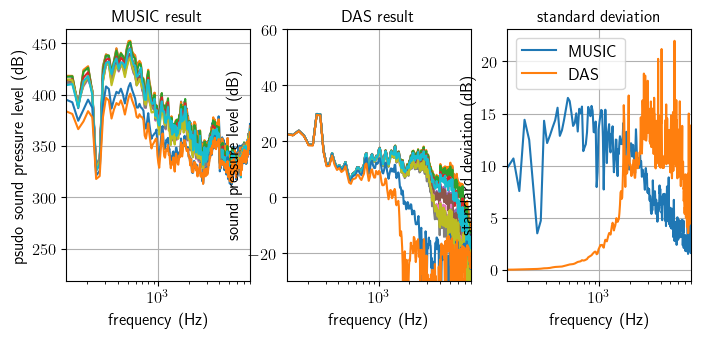

In [ ]:
import matplotlib.pyplot as plt

freq_range = [125, 8000]
plt.figure(figsize=ASPECT)
plt.subplot(1, 4, 1)
plt.title('MUSIC result')
plt.ylabel('psudo sound pressure level (dB)')
plt.xlabel('frequency (Hz)')
plt.semilogx(freq_list, result_muti_MUSIC)
plt.xlim(freq_range)
plt.grid()

plt.subplot(1, 4, 2)
plt.title('DAS result')
plt.ylabel('sound pressure level (dB)')
plt.xlabel('frequency (Hz)')
plt.semilogx(freq_list, result_muti_DAS)
plt.xlim(freq_range)
plt.ylim([-30, 60])

plt.grid()

plt.subplot(1, 4, 3)
plt.semilogx(freq_list, np.std(result_muti_MUSIC, axis=1))
plt.semilogx(freq_list, np.std(result_muti_DAS, axis=1))
plt.title('standard deviation')
plt.ylabel('standard deviation (dB)')
plt.xlabel('frequency (Hz)')
plt.legend(['MUSIC', 'DAS'])
plt.xlim(freq_range)
plt.grid()


In [ ]:
# write the modification of model to the file
o3d.io.write_point_cloud(cpcd_path, cpcd)
o3d.io.write_point_cloud(mic_path, pcd_mic)

True

In [ ]:
processor.pcd_show()

In [ ]:
# align the pcd coordinates
cpcd, picked_points = processor.coordinates_align()

origin = processor.apply_rotation(pcd_mic, picked_points)
# apply translation
pcd_mic = processor.apply_translation(pcd_mic, origin)

For point selecting
1) Please pick points using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
For crop the model
Press Y to switch to the ortho view, 
 K to lock the view and pick cropping area 
 C to crop 
 F to free view

 After picking points, press Q to quit, cropped model will be saved in variable "pcd"

Picked points: []
need 3 points to align


IndexError: list index out of range

In [ ]:
o3d.visualization.draw_geometries([cpcd, processor.mesh_frame, pcd_mic])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [ ]:
processor.pcd_crop()

Task exception was never retrieved
future: <Task finished name='Task-1566' coro=<WebSocketWriter.ping() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py:705> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 709, in ping
    await self._send_frame(message, WSMsgType.PING)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 686, in _send_frame
    self._write(header + message)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 696, in _write
    raise ConnectionResetError("Cannot write to closing transport

NameError: name 'processor' is not defined

In [ ]:
plotter_add_slice.show()

A view with name (P_0x1c5a4e4a020_22) is already registered
 => returning previous one


Widget(value="<iframe src='http://localhost:53282/index.html?ui=P_0x1c5a4e4a020_22&reconnect=auto' style='widt…

TypeError: object of type 'int' has no len()

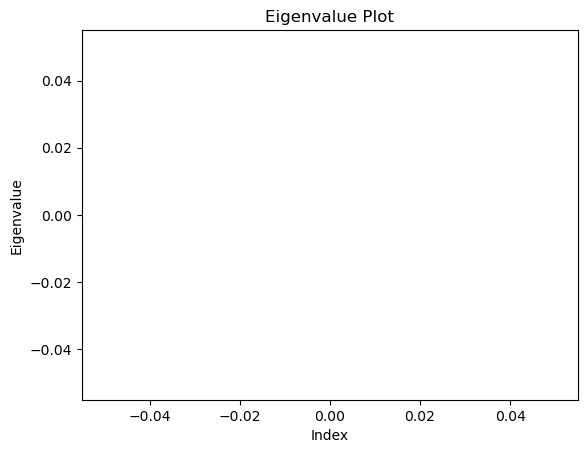

In [ ]:
import matplotlib.pyplot as plt

eigenval = BF_analysis.eigVal
plt.plot(eigenval)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue Plot')
plt.xticks(range(len(eigenval)), range(len(eigenval)))
plt.show()

